In [158]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt 
from numpy.polynomial.polynomial import polyfit
import myfunctions as mf
from statistics import mean
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import plotly
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
import matplotlib as mpl
from matplotlib.colors import LogNorm

# Directories

In [159]:
## Working directory
# head = "/exports/csce/datastore/geos/users/s1215319/paper3/version2/tlmfiles/tlm_validity/standard/"
head = "/exports/csce/datastore/geos/users/s1215319/paper3/version2/tlmfiles/tlm_validity/single_precision/"

#########################
## Sub-directory titles #
#########################

## Control (1-D model run)
control_dir = head + "1D_control/"
## Perturbations (TLM calculations)
pert_dir = head + "1D_perturb/"
## TLM matrices and index details
tlm_dir = head + "tlm/"

# Input

In [160]:
### Tracers and their layers of perturbations
##
## Options:
##
## H2O2 - 8:10 , 71 Ls
## O2 - 1:2 , 71 Ls
## O3 - 15:18, 251 Ls
## CH4 - 1:2, 251 Ls

perturbation_layers = { 'h2o2' : [8,10], 'o2' : [1,2], 'o3' : [15,18], 'ch4' : [1,2] }

### Solar Longitudes the files are produced at (for filename making)
solar_longitudes = {'h2o2' : 71, 'o2' : 71, 'o3' : 251, 'ch4' : 251}

### Perturbation Magnitudes
perturbation_magnitudes = ['-2', '-1', '0', '1']

# Tangent Linear Model 

### Tracer Indexing and TLM Extraction

In [161]:
## For ease of use for now, use 1 indexing file. These should be identical either way.
indexing_file_name = tlm_dir + "tracer_index.txt"
indx_file = open(indexing_file_name,"r")

indx_file_lines = indx_file.readlines()

## Number of tracers 
nqmx = int(indx_file_lines[3].split()[-1])

## Number of model layers
nlayermx = int(indx_file_lines[4].split()[-1])

## Number of model time-steps
ndt = int(indx_file_lines[2].split()[-1])

## Indexes of tracers within TLM vector space
tlm_idx = {}
for i in range(0,nqmx):
    tracer = indx_file_lines[6+i].split()[0]
    idx = int(indx_file_lines[6+i].split()[-1])

    tlm_idx[tracer] = idx
    
### TLM
TLM_DIC = {}
for ls in solar_longitudes:
    
    tlmname = tlm_dir + str(solar_longitudes[ls]) + "Ls.bin"
    
    tlm_data = np.fromfile(tlmname, dtype = np.float32(), sep='' )
    ## Re-shape the tlm binary data
    tlm = np.reshape(tlm_data,[ndt,nqmx*nlayermx,nqmx*nlayermx])
    for t in range(0,ndt):
        tlm[t,:,:] = np.transpose(tlm[t,:,:])
        
    TLM_DIC[ls] = np.float32(tlm)

### TLM Calculations

In [162]:

### Dictionary holding all relevant data to plot
### in following sections
DATA_TLM = {} 
DATA_1D = {}

DATA_TLM_MAG = {}
DATA_1D_MAG = {} ## Perturbation in magnitude compared to control runs

### ------------------------
### LOOP 1 : Perturbed Gases
### ------------------------
A=0
for gas in perturbation_layers:
    
    ### Solar Longitude of Test
    ls = solar_longitudes[gas]
    
    ### Range of Perturbation
    l_range = perturbation_layers[gas]
    
    ### Control 1-D model file
    ncdf_control = Dataset(control_dir+ str(ls) + "Ls.nc", "r")
    
    pertvec_1D_store = {}
    pertvec_TLM_store = {}
    
    pertvec_1D_store_mag = {}
    pertvec_TLM_store_mag = {}
    
    ### --------------------------------
    ### LOOP 2 : Perturbation Magnitudes
    ### --------------------------------
    B=0
    for mag in perturbation_magnitudes:
        
        pertfile_name = "5s_" + str(ls) + "Ls_" + "E" + str(mag)\
                        + "_" + str(l_range[0]) + "-" + str(l_range[1])\
                        + ".nc"

        ncdf_perturb = Dataset(pert_dir + "/" + gas + "/" + pertfile_name, "r")
        
        ### Perturbation Vector 
        ### as found by fully integrated
        ### 1-D model calculations
        pertvec_1D = np.zeros([ndt-1,nqmx*nlayermx])
        vec_1D = np.zeros([ndt-1,nqmx*nlayermx])
        
        ### Loop over tracers
        ### and construct the 
        ### perturbation vector
        for tracer in tlm_idx:
            
            idx = (tlm_idx[tracer]-1)*nlayermx 
            
            mmr_c = ncdf_control.variables[tracer][1:,:]
            
            vec_1D[:,idx:idx+nlayermx] = np.float32(mmr_c)
            
            vec_1D[ np.where(vec_1D <= 1.e-31) ] = 1.e-31
            
            mmr_p = ncdf_perturb.variables[tracer][:]
                     
            delta_mmr = np.float32(mmr_p - mmr_c)
                        
            pertvec_1D[:,idx:idx+nlayermx] = np.float32(delta_mmr)
            
        pertvec_1D_store[mag] = np.float32(pertvec_1D)
        pertvec_1D_store_mag[mag] = np.float32(pertvec_1D/vec_1D) 
        
        

        
        ### --------------------
        ### Tangent Linear Model 
        ### --------------------
        tlm = TLM_DIC[gas]
        pertvec_TLM = np.zeros([ndt,nqmx*nlayermx])
        pertvec_TLM[0,:] = pertvec_1D[0,:]
        
        for t in range(1,ndt-1):
            pertvec_TLM[t,:]=np.matmul( np.float32(tlm[t-1,:,:]), np.float32(pertvec_TLM[t-1,:]) )
            
            prec = np.abs(pertvec_TLM[t,:])/vec_1D[t,:]
        
            outofprec = np.where(prec<=1.e-6) 
            
            pertvec_TLM[t,outofprec] = 0.
            
        pertvec_TLM_store[mag] = np.float32(pertvec_TLM)
        pertvec_TLM_store_mag[mag] = np.float32(pertvec_TLM[:-1,:]/vec_1D)
        
    DATA_1D[gas] = pertvec_1D_store
    DATA_TLM[gas] = pertvec_TLM_store
    DATA_1D_MAG[gas] = pertvec_1D_store_mag 
    DATA_TLM_MAG[gas] = pertvec_TLM_store_mag


# Single Tracer Studies

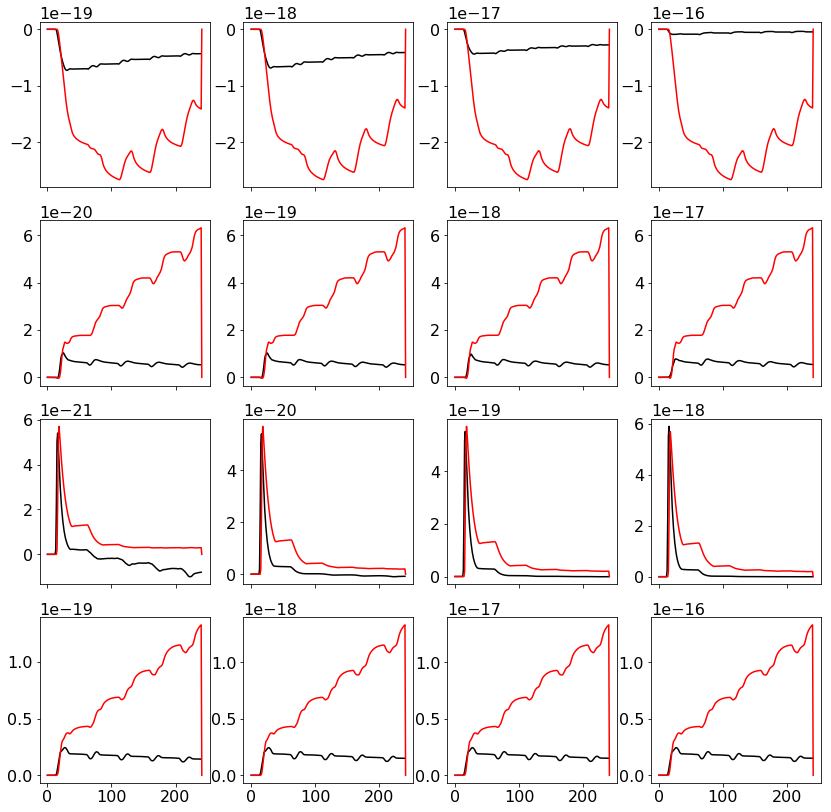

In [140]:
studied_tracers = ['hcho', 'hcho', 'hcho' ,'hcho']

fig,axs = plt.subplots(4,4,sharex=True,sharey=False)
fig.set_figheight(14)
fig.set_figwidth(14)


case_i=0
b=0
for case in perturbation_layers:
    
    ## 1D Perturbation Vectors
    values_1D = DATA_1D[str(case)]
    
    ## Perturbation vectors from the TLM
    tlm_CASES = DATA_TLM[str(case)]
    
    ## Precision calculations         
    gas = studied_tracers[case_i]
    
    pert_layer = perturbation_layers[case] 
    
    Jidx = (tlm_idx[gas]-1)*nlayermx + int(pert_layer[0]) - 1
    
    for mag in perturbation_magnitudes:
        
        dj_1d = values_1D[mag][:,Jidx]
        dj_tlm = tlm_CASES[mag][:,Jidx]
        
        axs[case_i,b].plot(dj_1d,color='k')
        axs[case_i,b].plot(dj_tlm,color='r')

        b=b+1
        
    b=0
    case_i = case_i + 1

# Plotting

DATA_1D[gas] : holds a [4, ndt, nqmx*nlayermx] array of perturbations with time produced by an initial perturbation of [gas] as calcuated by the 1-D model

DATA_TLM[gas] : ditto as above, but for TLM calculations

## Plot 1 - X and Y axis are Absolute Perturbations

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


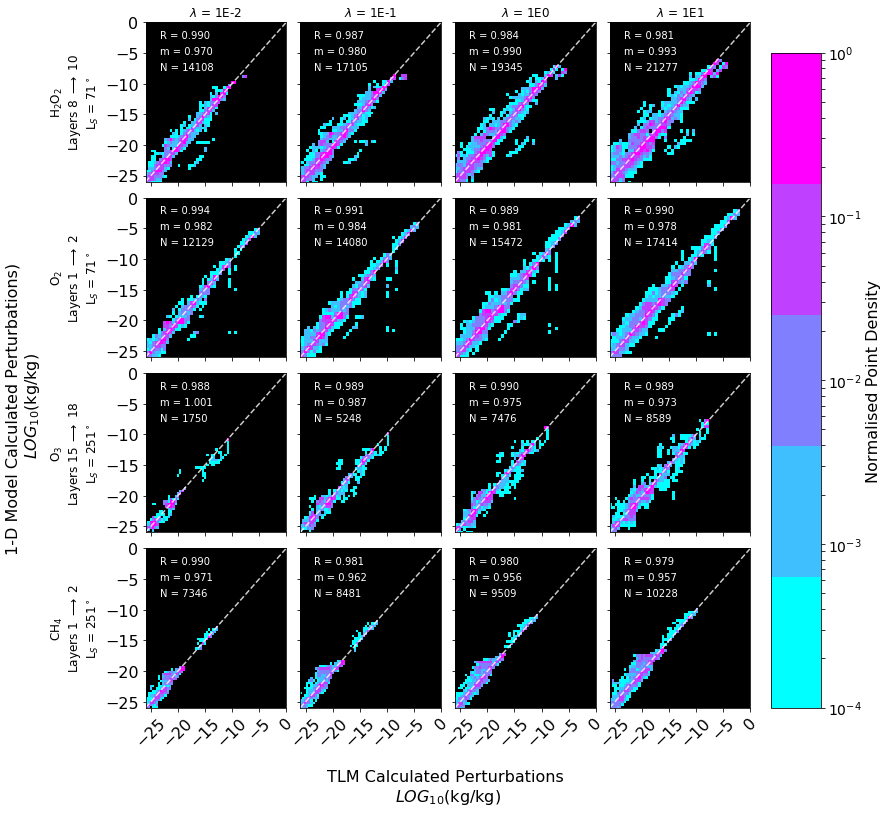

In [163]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

## Sols of data to plot 
sol_limit = 3

## Time-steps per sol in the 1-D model
nstep_sol = 48

## Construct figure
fig,axs = plt.subplots(4,4,sharex=True,sharey=True)
fig.set_figheight(14)
fig.set_figwidth(14)

## Colormap for 2-D histograms
# my_cmap = plt.cm.cool
my_cmap=plt.cm.get_cmap('cool', 5)

## All bins with < 1 point will 
## be background color [black]
my_cmap.set_under('k',1)

## X and Y axis labels
fig.subplots_adjust(hspace=0.1,wspace=0.1, left = 0.2, bottom = 0.2,right=0.8)
fig.text(0.5,0.12,"TLM Calculated Perturbations \n$LOG_{10}$(kg/kg)", horizontalalignment='center',\
            verticalalignment='center', fontsize = 16)
fig.text(0.08,0.5,"1-D Model Calculated Perturbations) \n$LOG_{10}$(kg/kg)", fontsize = 16, rotation = 90.,horizontalalignment='center',\
            verticalalignment='center')

## colorbar for normalised
## number density of 2-D 
## histogram
cbar_ax = fig.add_axes([0.82, 0.2, 0.05, 0.65])
norm = mpl.colors.LogNorm(vmin=1.e-4, vmax=1.)
# cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,\
#                                 norm=norm)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=my_cmap,\
                                norm=norm)
cb1.ax.tick_params(labelsize=14)
cb1.ax.set_ylabel("Normalised Point Density",fontsize=16)

### -----------------------
### 1.0 Loop : Tracer [Row]
### -----------------------
A=0
for gas in perturbation_layers:
    
    ### Solar Longitude (degrees)
    ls = solar_longitudes[gas] 
   
    ### Relevant Arrays
    data_1D = DATA_1D[gas]
    data_TLM = DATA_TLM[gas]
    mag_data_1D = DATA_1D_MAG[gas]
    
    ### Layers 
    lyrs = perturbation_layers[gas]    

    ### ---------------------------------
    ### 2.0 Loop : Perturbation Magnitude
    ### ---------------------------------
    B=0
    for mag in perturbation_magnitudes:
               
        ## Perturbation vectors, absolute due to log
        ## plot not enabling < 0 values
        vec_1D = np.abs(data_1D[mag][:nstep_sol*sol_limit,:])
        vec_TLM = np.abs(data_TLM[mag][:nstep_sol*sol_limit,:])
        
        vec_1D_mag = np.abs(mag_data_1D[mag][:nstep_sol*sol_limit,:])        
        
        ## Flatten to a 1-D array
        vec_1D = np.ndarray.flatten(vec_1D)
        vec_TLM = np.ndarray.flatten(vec_TLM)

        vec_1D_mag = np.ndarray.flatten(vec_1D_mag)
        
        lowprecision = np.where( np.abs(vec_1D_mag) >= 1.e-6 )

        ## Where 1-D perturbations are close to precision errors ignore them
        vec_1D = vec_1D[lowprecision]
        vec_TLM = vec_TLM[lowprecision]
        
        ## Set a floor for the perturbations 
        vec_0s = np.where(vec_1D >= 1.e-31)
        vec_1D = vec_1D[vec_0s]
        vec_TLM = vec_TLM[vec_0s]
        
        vec_0s = np.where(vec_TLM >= 1.e-31)
        vec_1D = vec_1D[vec_0s]
        vec_TLM = vec_TLM[vec_0s]
        


        
        ## Background color
        axs[A,B].set_facecolor('k')

        ## Create histogram
        
#         histo= axs[A,B].hist2d( np.log10(vec_TLM), np.log10(vec_1D), (48,48), normed=True ,cmap=my_cmap, cmin=1.e-3)#,norm=LogNorm())
        histo= axs[A,B].hist2d( np.log10(vec_TLM), np.log10(vec_1D), (48,48), norm=mpl.colors.LogNorm()\
                               , cmin=1.e-4, cmap = my_cmap)#,norm=LogNorm())

        
        ## Axis limits
        axs[A,B].set_ylim(-26,0)
        axs[A,B].set_xlim(-26,0)
        axs[A,B].tick_params(axis='x', rotation=45)
        
        ### Statistical Analysis
        ## R value
        corr, _ = pearsonr(np.log10(vec_TLM), np.log10(vec_1D))
        ## m [gradient of l.o.b.f]
        m, y_int = best_fit_slope_and_intercept(np.float64(np.log10(vec_1D)),np.float64(np.log10(vec_TLM)))
        
        ## Write data on plots
        c = "w"
        axs[A,B].text( 0.1, 0.9, "R = " + "{:4.3F}".format(corr), fontsize = 10, transform=axs[A,B].transAxes, color = c)
        axs[A,B].text( 0.1, 0.8, "m = " + "{:4.3F}".format(m), fontsize = 10, transform=axs[A,B].transAxes, color = c)
        axs[A,B].text( 0.1, 0.7, "N = " + str(np.size(vec_1D)), fontsize = 10, transform=axs[A,B].transAxes, color = c)

        ## Information on the Y i.e. initial magnitude of perturbation
        if ( A == 0 ):
            axs[A,B].set_title("$\lambda$ = 1E" + str(mag), fontsize = 12)
        ## Info. on the X i.e. initial perturbed gas, it's location in the model column, solar longitude
        if ( B == 0 ):
            l1 = mf.latex_name(gas) 
            l2 = "Layers " + str(lyrs[0]) + " $\longrightarrow$ " + str(lyrs[1])
            l3 = "L$_S$ = " + str(ls) + "$^\circ$"
            
            axs[A,B].set_ylabel(l1 + "\n" + l2 + "\n" + l3, fontsize=12)
# #             axs[a,b].set_ylabel("Case " + str(a+1) , fontsize = 12)
#             axs[A,B].set_ylabel(mf.latex_name(gas) + "\n Layer " + str(pert_layer[a]) \
#                                + "\n" + latitudes_latex[a] + ", L$_S$ = " + solar_longitudes[a] + "$^\circ$",\
#                                fontsize = 12)

        
        axs[A,B].plot(axs[A,B].get_xlim(), axs[A,B].get_ylim(), ls="--", color = 'w', alpha = 0.8)
        print(A,B)
        
        B=B+1
        
    A=A+1
    B=0
    
    
## Ticks 
ticks = list( np.arange(-25,5,5) )
axs[0,0].set_xticks(ticks)
axs[0,0].set_yticks(ticks)
    

In [146]:
fig.savefig("/exports/csce/datastore/geos/users/s1215319/paper3/version2/figures/A2_TLMvs1D.png",dpi=500)

## Plot 2 - X and Y axis are Relative Perturbations

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


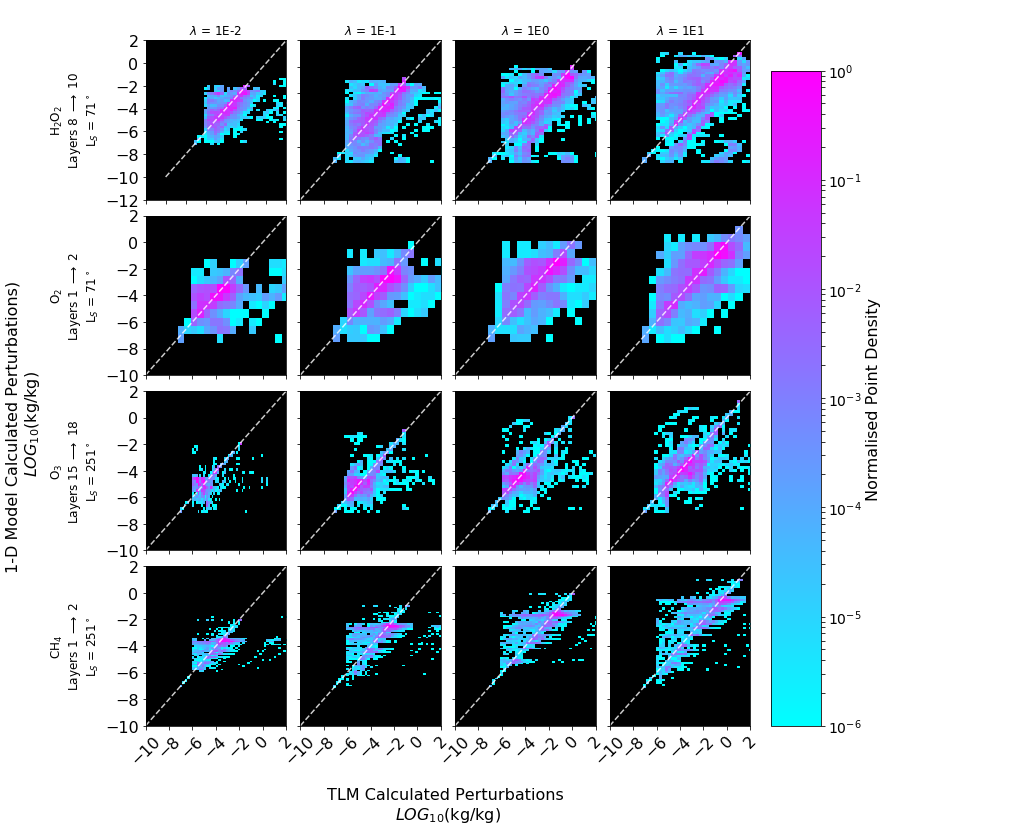

In [153]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b

## Sols of data to plot 
sol_limit = 3*5

## Time-steps per sol in the 1-D model
nstep_sol = 48

## Construct figure
fig,axs = plt.subplots(4,4,sharex=True,sharey=True)
fig.set_figheight(14)
fig.set_figwidth(14)

## Colormap for 2-D histograms
my_cmap = plt.cm.cool
## All bins with < 1 point will 
## be background color [black]
my_cmap.set_under('k',1)

## X and Y axis labels
fig.subplots_adjust(hspace=0.1,wspace=0.1, left = 0.2, bottom = 0.2,right=0.8)
fig.text(0.5,0.12,"TLM Calculated Perturbations \n$LOG_{10}$(kg/kg)", horizontalalignment='center',\
            verticalalignment='center', fontsize = 16)
fig.text(0.08,0.5,"1-D Model Calculated Perturbations) \n$LOG_{10}$(kg/kg)", fontsize = 16, rotation = 90.,horizontalalignment='center',\
            verticalalignment='center')

## colorbar for normalised
## number density of 2-D 
## histogram
cbar_ax = fig.add_axes([0.82, 0.2, 0.05, 0.65])
cmap = mpl.cm.cool
norm = mpl.colors.LogNorm(vmin=1.e-6, vmax=1.)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,\
                                norm=norm)
cb1.ax.tick_params(labelsize=14)
cb1.ax.set_ylabel("Normalised Point Density",fontsize=16)


### -----------------------
### 1.0 Loop : Tracer [Row]
### -----------------------
A=0
for gas in perturbation_layers:
    
    ### Solar Longitude (degrees)
    ls = solar_longitudes[gas] 
   
    ### Relevant Arrays
    data_1D = DATA_1D_MAG[gas]
    data_TLM = DATA_TLM_MAG[gas]
    
    ### Layers 
    lyrs = perturbation_layers[gas]    

    ### ---------------------------------
    ### 2.0 Loop : Perturbation Magnitude
    ### ---------------------------------
    B=0
    for mag in perturbation_magnitudes:
               
        ## Perturbation vectors, absolute due to log
        ## plot not enabling < 0 values
        vec_1D = np.abs(data_1D[mag][:nstep_sol*sol_limit,:])
        vec_TLM = np.abs(data_TLM[mag][:nstep_sol*sol_limit,:])
        
        ## Flatten to a 1-D array
        vec_1D = np.ndarray.flatten(vec_1D)
        vec_TLM = np.ndarray.flatten(vec_TLM)

        ## Set a floor for the perturbations 
        vec_0s = np.where(vec_1D >= 1.e-31)
        vec_1D = vec_1D[vec_0s]
        vec_TLM = vec_TLM[vec_0s]
        
        vec_0s = np.where(vec_TLM >= 1.e-31)
        vec_1D = vec_1D[vec_0s]
        vec_TLM = vec_TLM[vec_0s]
        
        ## Background color
        axs[A,B].set_facecolor('k')

        ## Create histogram
        
#         histo= axs[A,B].hist2d( np.log10(vec_TLM), np.log10(vec_1D), (48,48), normed=True ,cmap=my_cmap, cmin=1.e-3)#,norm=LogNorm())
        histo= axs[A,B].hist2d( np.log10(vec_TLM), np.log10(vec_1D), (50,50), norm=mpl.colors.LogNorm()\
                               , cmin=1.e-6, cmap = my_cmap)

        
        ## Axis limits
        axs[A,B].set_ylim(-10,2)
        axs[A,B].set_xlim(-10,2)
        axs[A,B].tick_params(axis='x', rotation=45)
        
#         ### Statistical Analysis
#         ## R value
#         corr, _ = pearsonr(np.log10(vec_TLM), np.log10(vec_1D))
#         ## m [gradient of l.o.b.f]
#         m, y_int = best_fit_slope_and_intercept(np.float64(np.log10(vec_1D)),np.float64(np.log10(vec_TLM)))
        
#         ## Write data on plots
#         c = "w"
#         axs[A,B].text( 0.1, 0.9, "R = " + "{:4.3F}".format(corr), fontsize = 10, transform=axs[A,B].transAxes, color = c)
#         axs[A,B].text( 0.1, 0.8, "m = " + "{:4.3F}".format(m), fontsize = 10, transform=axs[A,B].transAxes, color = c)
#         axs[A,B].text( 0.1, 0.7, "N = " + str(np.size(vec_1D)), fontsize = 10, transform=axs[A,B].transAxes, color = c)

        ## Information on the Y i.e. initial magnitude of perturbation
        if ( A == 0 ):
            axs[A,B].set_title("$\lambda$ = 1E" + str(mag), fontsize = 12)
        ## Info. on the X i.e. initial perturbed gas, it's location in the model column, solar longitude
        if ( B == 0 ):
            l1 = mf.latex_name(gas) 
            l2 = "Layers " + str(lyrs[0]) + " $\longrightarrow$ " + str(lyrs[1])
            l3 = "L$_S$ = " + str(ls) + "$^\circ$"
            
            axs[A,B].set_ylabel(l1 + "\n" + l2 + "\n" + l3, fontsize=12)
# #             axs[a,b].set_ylabel("Case " + str(a+1) , fontsize = 12)
#             axs[A,B].set_ylabel(mf.latex_name(gas) + "\n Layer " + str(pert_layer[a]) \
#                                + "\n" + latitudes_latex[a] + ", L$_S$ = " + solar_longitudes[a] + "$^\circ$",\
#                                fontsize = 12)

        
        axs[A,B].plot(axs[A,B].get_xlim(), axs[A,B].get_ylim(), ls="--", color = 'w', alpha = 0.8)
        print(A,B)
        
        B=B+1
        
    A=A+1
    B=0
    
    
## Ticks 
ticks = list( np.arange(-12,4,2) )
axs[0,0].set_xticks(ticks)
axs[0,0].set_yticks(ticks)
    

# Adjoint Sensitivity Analysis

Here we perform the same as above, but for back-traced sensitivities.

## Weird : test not great, zeros at the start should *not* be 0. Check test structure, then trial use of non-diurnal chemistry runs.

NEW TEST TO STUDY : http://www.met.reading.ac.uk/~darc/nerc_training/reading2014/lawless_var.pdf


## Current Test

$(\hat{\vec{PQ}}^t,\mathbf{P}_t \vec{PQ}"^0)$ = $(\mathbf{P}_t^T  \hat{\vec{PQ}}^t,\vec{PQ}"^0)$

Need:

1. Construction of the Sensitivity Vector $\hat{\vec{PQ}}^t$ for all timesteps $0 \leq t \leq N$ 
2. Construction of the Transition Matrices $\mathbf{P}_t = \prod_{i = -t}^{0}\mathbf{A}_{-i}$ for all timesteps $0 \leq t \leq N$ for Tangent Linear Model matrix $\mathbf{A}_t$
3. Calculations of the LHS and RHS, and assessing their validity.

240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240


(-1e-13, 1e-13)

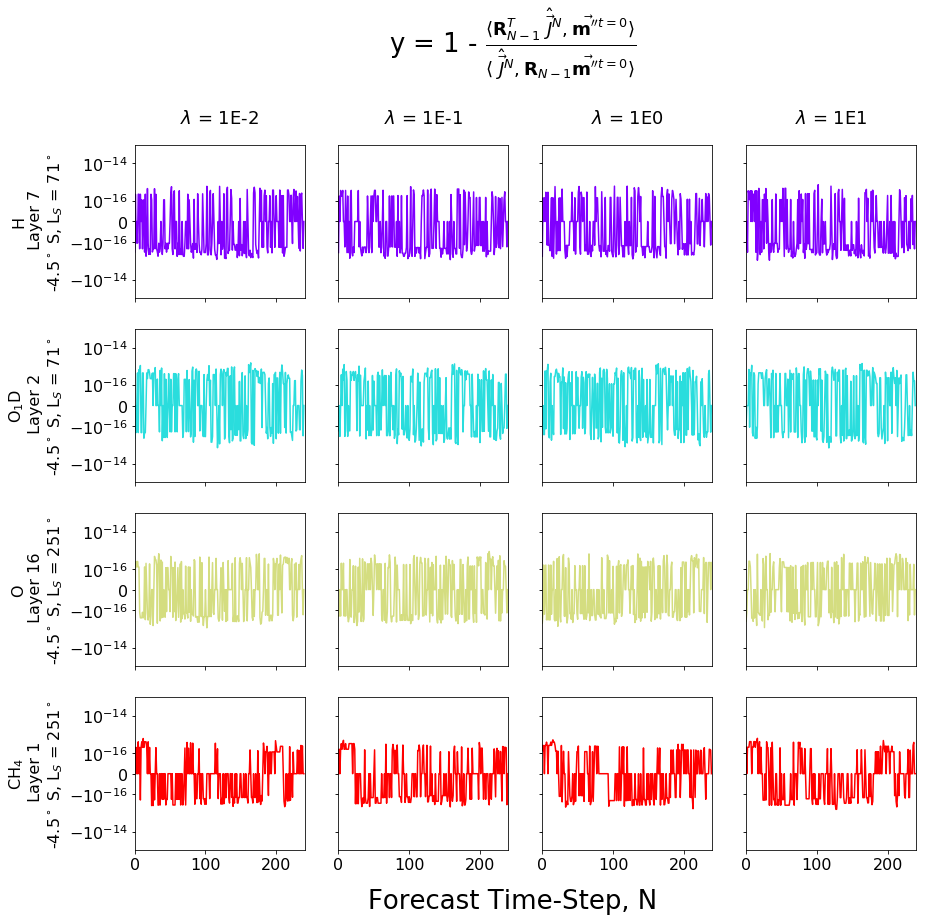

In [148]:

## Global parameters
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Figure construction
fig,axs = plt.subplots(4,4,sharex=True,sharey=True)
fig.set_figheight(14)
fig.set_figwidth(14)


####################################
#### Loop One : Initial Perturbation
####################################
case_i = 0

t_study = 48*5

studied_J = ['h','o1d','o','ch4']
pert_layer = [7,2,16,1]

## Axis indexes
a=0
b=0

## Colors 
color=iter(cm.rainbow(np.linspace(0,1,4)))


for case in perturbation_layers:
    
    ## 1D Perturbation Vectors
    values_1D = DATA_1D[case]#pert_1D_dictionary[case]
    
    ## Perturbation vectors from the TLM
    tlm_CASES = DATA_TLM[case]
    
    ## Precision calculations 
#     precision_CASES = pert_precision_1D_dictionary[case] 
    
    ##################################
    ## Tangent Linear Model extraction 
    ## for the temporal and spatial 
    ## case being studied 
    ##################################
    
    ## Tangent Linear Model files of this case study
#     tlm_file_name = tlm_dir + filecores[case_i] + "_tlm.bin"
    tlm_file_name=tlm_dir + str(solar_longitudes[case]) + "Ls.bin"
    
    adjoint_data = np.fromfile(tlm_file_name, dtype = np.float64(), sep='' )
    
    ## Re-shape the adjoint binary data (FORTRAN and Python switch Column/Row major notations,
    ## so when the TLM matrix is saved in the Fortran binary file, it is read as the transpose
    ## i.e. the Adjoint when Python is used)
    adjoint = np.reshape(tlm_data,[ndt,nqmx*nlayermx,nqmx*nlayermx])
    
    tlm = np.empty([t_study,nqmx*nlayermx,nqmx*nlayermx])
    
    P = np.empty(np.shape(tlm))
    
    ########################################
    ## Construct the transition matrices P^t
    ## and sensitivity vectors \hat{PQ}^t
    ########################################
    P[-1,:,:] = np.transpose(adjoint[t_study-1,:,:])
    hat_PQ = np.zeros([t_study,nqmx*nlayermx])
    
    ## Index to initialise the sensitivity
    idx_J = (tlm_idx[studied_J[case_i]] - 1)*nlayermx + int(pert_layer[case_i]) - 1
    hat_PQ[-1,idx_J] = 1.0 
    
    for t in range(t_study-2,-1,-1):
        tlm[t,:,:] = np.transpose(adjoint[t,:,:])
        
        ## Transition matrix construction
        P[t,:,:] = np.matmul(P[t+1,:,:],tlm[t,:,:])
        
        ## Sensitivity vector construction
        hat_PQ[t,:] = np.matmul(adjoint[t,:,:],hat_PQ[t+1,:])
        
    
    #####################################
    ## Loop Two : Perturbation Magnitudes
    #####################################
    for mag in perturbation_magnitudes:
        
        ## We have:
        ## 1. Sensitivity Vectors : hat_PQ 
        ## 2. Transition Matrices : P 
        ## 3. Extract the TLM calculated PQ" values:

        ## The 1-D calculated value of dJ 
        delta_PQ_1D = values_1D[mag][:t_study,:]
        dJ_1D = delta_PQ_1D[-1,idx_J]
        
        ## PQ" values 
        delta_PQ = tlm_CASES[mag]
        
        
        ## Precision values 
#         precision = precision_CASES[mag]
        
#         delta_PQ[np.where(precision < 1.e-6)] = 0.
        
        #######################################################
        ## Loop Three : Iteration over timesteps
        ## Iterate over time and perform the inner product test
        #######################################################
        
        LHS = np.empty([t_study])
        RHS = np.empty([t_study])
        
        ################ 
        # TRIAL 2
        ################
        
        ## ( hat{PQ}^t, P_t \vec{PQ"}^{t=0}  ) = ( P_t^T \hat{PQ}^t , \vec{PQ"}^{t=0} )
        
        for t in range(0,t_study):
            
            
            LHS[t] = np.inner(\
                             hat_PQ[t,:],\
                             np.matmul( P[t,:,:], delta_PQ[0,:] )\
                             )
            
            P_T = np.transpose(P[t,:,:])
            
            RHS[t] = np.inner(\
                             np.matmul(P_T,hat_PQ[t,:]),\
                             delta_PQ[0,:]\
                             )
                
        if ( b == 0 ):
            c = next(color)
            
        axs[a,b].plot((RHS-LHS)/RHS,color=c)
        
        axs[a,b].set_xlim(0,t_study)
        
        print(t_study)
        
        ## Formatting figure 
        if ( a == 0 ):
            title = "$\lambda$ = 1E" + mag
            axs[a,b].set_title(title, fontsize = 18, y=1.1)
        if ( b == 0 ):
            axs[a,b].set_ylabel(mf.latex_name(studied_J[case_i]) + "\n Layer " + str(pert_layer[a]) \
                               + "\n" + "-4.5$^\circ$ S" + ", L$_S$ = " + str(solar_longitudes[case]) + "$^\circ$",\
                               fontsize = 16)
#         if ( a == 3 ):
#             axs[a,b].set_xlabel("Number of Time-Steps, N", fontsize = 14)
        
        b = b + 1
    
    case_i = case_i + 1
    
    a=case_i
    b=0
    
    
fig.subplots_adjust( top = 0.85, bottom = 0.15 )

numerator_1 = "\\langle \ \hat{\\vec{J}}^N , \mathbf{R}_{N-1} \\vec{\mathbf{m^{\prime\prime}}}^{t=0} \\rangle"
numerator_2 = "\\langle \mathbf{R}_{N-1}^T \ \hat{\\vec{J}}^N ,  \\vec{\mathbf{m^{\prime\prime}}}^{t=0} \\rangle"
numerator =   "{"  + numerator_2 + "}"

denominator = "{"+ numerator_1 + "}"

ylab = "y = 1 - $\\frac" + numerator + denominator + "$" #"$\\frac" + numerator + denominator + "$"
xlab ="Forecast Time-Step, N"

# fig.text(0.05,0.5, ylab , rotation = 90., fontsize = 26., horizontalalignment = "center",\
#                 verticalalignment='center')
fig.text(0.5,0.95, ylab, fontsize = 26, horizontalalignment = "center",\
                verticalalignment='center')

fig.text(0.5,0.1, xlab, fontsize = 26, horizontalalignment = "center",\
                verticalalignment='center')


axs[0,0].set_yscale("symlog",linthreshy=1.e-16)
axs[0,0].set_ylim(-1.e-13,1.e-13)

In [149]:
fig.savefig("/exports/csce/datastore/geos/users/s1215319/paper3/version2/figures/A3_adjoint_temporalinvar.png",dpi=500)

## PROOF OF TEMPORAL INVARIANCE 

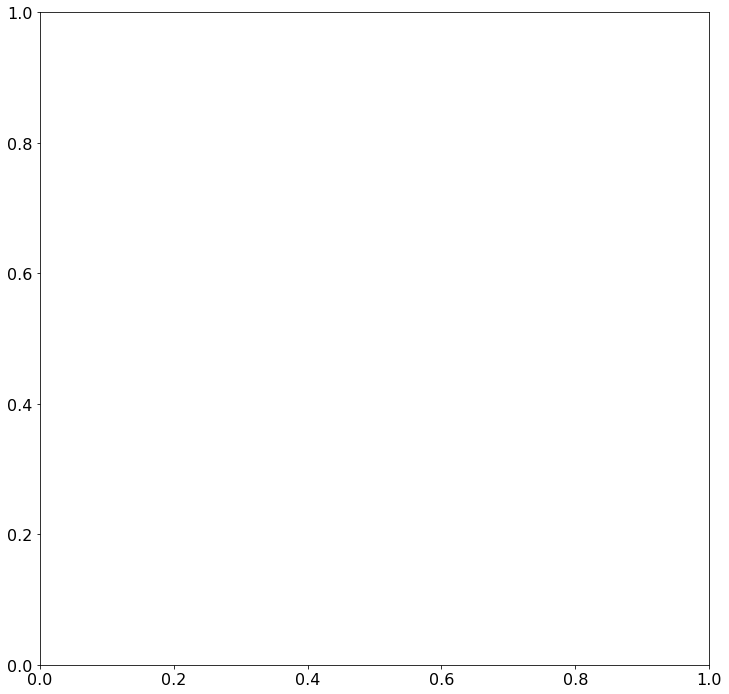

In [150]:
case = 'o2'

j_t   = 48*3 

## Figure
fig,axs = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)

##################################
## Files
##################################
tlm_file_name=tlm_dir + str(solar_longitudes[case]) + "Ls.bin"
tlm_data = np.fromfile(tlm_file_name, dtype = np.float32(), sep='' )

## Re-shape the tlm binary data
tlm = np.reshape(tlm_data,[ndt,nqmx*nlayermx,nqmx*nlayermx])
for t in range(0,ndt):
    tlm[t,:,:] = np.transpose(tlm[t,:,:])

tlm = tlm[:j_t,:,:]
    
#############################
## dJ from 1-D and TLM models
#############################
case_gas = case

dPQ_1D_allmags =  DATA_1D[case_gas]
dPQ_TLM_allmags = DATA_TLM[case_gas]
dPQ_precision_allmags = DATA_1D

Text(0.5,1,'O$_2$, Layers 1-2\n4.5$^\\circ$S, L$_S$ = 71$^\\circ$\n$\\lambda$ = 1E-1')

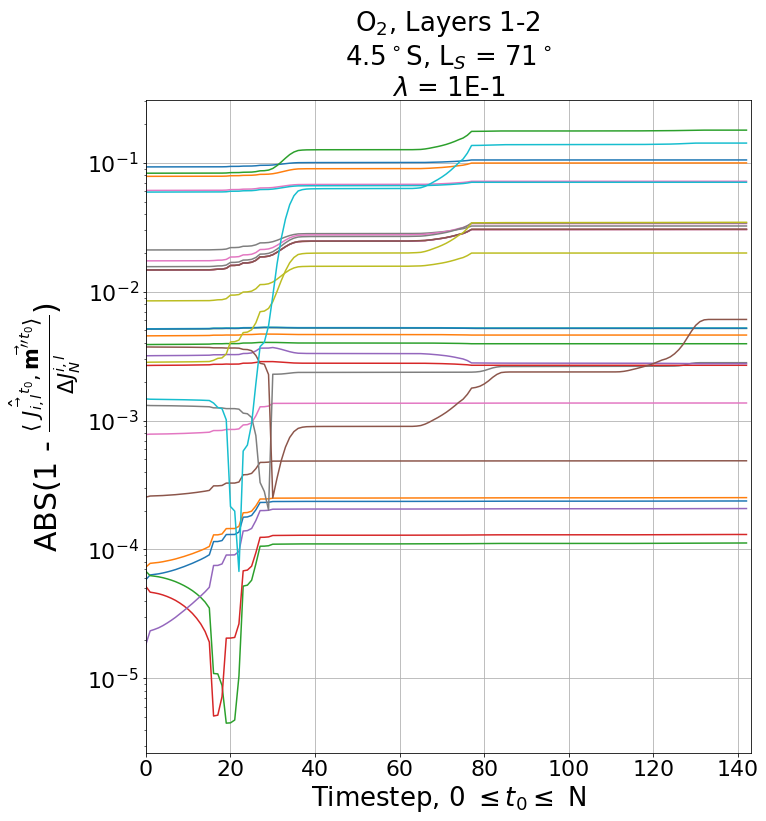

In [151]:
case = 'o2'

j_t   = 48*3 

## Figure
fig,axs = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(12)

##################################
## Files
##################################
tlm_file_name=tlm_dir + str(solar_longitudes[case]) + "Ls.bin"
tlm_data = np.fromfile(tlm_file_name, dtype = np.float32(), sep='' )

## Re-shape the tlm binary data
tlm = np.reshape(tlm_data,[ndt,nqmx*nlayermx,nqmx*nlayermx])
for t in range(0,ndt):
    tlm[t,:,:] = np.transpose(tlm[t,:,:])

tlm = tlm[:j_t,:,:]
    
#############################
## dJ from 1-D and TLM models
#############################
case_gas = case

dPQ_1D_allmags =  DATA_1D[case_gas]
dPQ_TLM_allmags = DATA_TLM[case_gas]
dPQ_precision_allmags = DATA_1D_MAG[case_gas]

#### 1 magnitude for now (e-2)
dPQ_1D = dPQ_1D_allmags['-1'][:j_t,:]
dPQ_TLM = dPQ_TLM_allmags['-1'][:j_t,:]
dPQ_prec = dPQ_precision_allmags['-1'][:j_t,:]

#########################
## Forecast Element Index
#########################

layer_addition = 0

for i in range(0,nqmx*nlayermx):
    j_index = i
    
    dJ_1D = dPQ_1D[-1,j_index]
    dJ_TLM = dPQ_TLM[-1,j_index]
    dJ_1D_mag = dPQ_prec[-1,j_index]
    
    if (np.abs(dJ_TLM) < 1.e-16):
        continue
    
    if (np.abs(dJ_1D) < 1.e-16 ):
        continue

    if ( np.abs(dJ_1D_mag) < 1.e-6):
        continue
    
        
    hat_J = np.zeros([j_t,nqmx*nlayermx])
    
    hat_J[-1,j_index] = 1.E0
    
    test_values = np.zeros(j_t-1)
    
    for t in range(j_t-2,-1,-1):
        adjoint = np.transpose(tlm[t,:,:])

        hat_J[t,:] = np.dot(adjoint,hat_J[t+1,:])
        
        test_calculation = np.dot( hat_J[t,:], dPQ_TLM[t,:] )
        test_values[t] = test_calculation/dJ_1D

    axs.plot(np.abs(test_values-1.))
    axs.set_yscale("log")
    axs.grid(True)
    
fig.subplots_adjust(left=0.2)
numer = "{ \\langle \ \hat\\vec{J_{i,l}}^{t_0}, \\vec{\mathbf{m^{\prime\prime}}}^{t_0} \\rangle }"
denom = "{\Delta J_N^{i,l}}"
axs.set_ylabel("ABS(1 - $\\frac" + numer + denom + "$)", fontsize = 30)
axs.set_xlabel("Timestep, 0 $\leq t_0 \leq$ N", fontsize = 26)
axs.tick_params("both",labelsize = 22)
axs.set_xlim(0,j_t-1)
# axs.set_ylim(-1.e-12,1.e-12)
# axs.set_ylim(1.e-5,1.e0)

# axs.set_yticks([-1.e-12, -1.e-14, -1.e-16, -1.e-18, -1.e-20, -1.e-22,\
#                0., 1.e-22, 1.e-20, 1.e-18, 1.e-16, 1.e-14, 1.e-12 ])
axs.set_title("O$_2$, Layers 1-2\n4.5$^\circ$S, L$_S$ = 71$^\circ$\n$\lambda$ = 1E-1", fontsize = 26)


In [152]:
fig.savefig("/exports/csce/datastore/geos/users/s1215319/paper3/version2/figures/A4_adjoint_O2_accuracy.png",dpi=500)